In [1]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

# Objective
### To predict building prices based on changes to property features.
- The features available for change will be those that can be offered as # renovation services to clients.

__Data Source__
data.boston.gov

__Files Used__
- 2022 Assessment file
- Building Inventory
- File of all historical renovation dates collected for assessment files from 2021 to 2004

In [2]:
#imports

import json
import urllib.request
import pandas as pd

# url = 'https://data.boston.gov/api/3/action/datastore_search?resource_id=4b99718b-d064-471b-9b24-517ae5effecc'
# import data sets for 2022 and 2021
url2022='https://data.boston.gov/dataset/e02c44d2-3c64-459c-8fe2-e1ce5f38a035/resource/4b99718b-d064-471b-9b24-517ae5effecc/download/fy2022pa-4.csv'  
url2021='https://data.boston.gov/dataset/e02c44d2-3c64-459c-8fe2-e1ce5f38a035/resource/c4b7331e-e213-45a5-adda-052e4dd31d41/download/data2021-full.csv'
# fileobj = urllib.request.urlopen(url)
# response_dict = json.loads(fileobj.read())
# data=response_dict["result"]
# print(response_dict["result"])


#import building inventory 
buildinginventory='https://data.boston.gov/dataset/f2a82340-1f9c-49fb-a60b-b5655c9a7931/resource/391a32e6-d4bb-48d3-a990-cb35a5768a40/download/building_inventory_021020.csv'
buildinginventorydf=pd.read_csv(buildinginventory)
#rename building inventory columns with prefix bi_ to distinguish when joining
buildinginventorycolumns=buildinginventorydf.columns
# print(buildinginventorycolumns)
buildinginventorycolumns=["bi_"+x for x in buildinginventorycolumns]
buildinginventorydf.columns=buildinginventorycolumns
# buildinginventorydf1=buildinginventorydf.drop_duplicates(subset=['bi_pid_long'])
print(len(buildinginventorydf))
buildinginventorydf1=buildinginventorydf.copy()
buildinginventorydf1=buildinginventorydf1.dropna(subset=["bi_pid_long"])
print(len(buildinginventorydf1))
buildinginventorydf1=buildinginventorydf1[~buildinginventorydf1["bi_pid_long"].str.contains('[A-Za-z]',na=False)]
buildinginventorydf1["bi_pid_long"]=buildinginventorydf1["bi_pid_long"].astype(int,errors="ignore")
buildinginventorydf1["bi_pid_long"]=buildinginventorydf1["bi_pid_long"].astype(str)

# for each file, merge with building inventory and add to list
framelist=[[url2022,'2022'],[url2021,'2021']]
dflist=[]
for frame in framelist:
  df=pd.read_csv(frame[0])
  df["filename"]=frame[1]
  df["PID"]=df["PID"].astype(str)
  
  df=df.merge(buildinginventorydf1, left_on='PID', right_on="bi_pid_long",how='left')
  dflist.append(df)


# select 2022 file for regression
df1=dflist[0]


# filter to single family owner occ
# df2=df1[((df1["LU_DESC"]=="SINGLE FAM DWELLING") |(df1["LU_DESC"]=="RESIDENTIAL CONDO"))&(df1["OWN_OCC"]=="Y")]
df2=df1[((df1["LU_DESC"]=="SINGLE FAM DWELLING"))&(df1["OWN_OCC"]=="Y")]
print(len(df2))
# df1.groupby(by="LU_DESC")["LU_DESC"].count().reset_index(name="LU_DESC_count").sort_values(by="LU_DESC_count",ascending=False)

# calculate number of na rows for 2022 assessment data set
df2_na_stats=pd.DataFrame(df2.isnull().sum()/len(df2))
df2_na_stats.to_csv("na_counts2.csv")
df2_na_stats


##download csv to local
# from google.colab import files
# files.download("masterrenolist.csv")


# # # read in remodel df
# import pandas as pd
# import ast
# remodeldf=pd.read_csv("/content/masterrenolist.csv")

# # bring in historical remodel data
# remodeldf["years"]=remodeldf["1"].apply(lambda x: ast.literal_eval(x))
# listcol=remodeldf["years"].to_list()
# lens=[len(x) for x in listcol]
# lens

# remodeldf["remodelcount"]=lens
# remodeldf

# listcol=remodeldf["years"].to_list()
# maxlist=[max(x,default=0) for x in listcol]

# remodeldf["latestremodel"]=maxlist
# remodeldf["0"]=remodeldf["0"].astype(str)

# df3=df2.merge(remodeldf, left_on='PID', right_on="0",how='left')

# # change types on some fields

# retype=["TOTAL_VALUE","BLDG_VALUE","LAND_VALUE","GROSS_TAX"]
# for r in retype:
#   print(r)
#   df3[r]=df3[r].str.replace(",","").str.replace("$","").astype(float)


# # select numeric fields only
# pd.set_option("display.max_columns", None)
# numcolumns=df3.select_dtypes(include=["float","int"])
# numcolumns



# # read in remodel df
import pandas as pd
import ast
remodeldf=pd.read_csv("masterrenolist.csv")

# bring in historical remodel data
remodeldf["years"]=remodeldf["1"].apply(lambda x: ast.literal_eval(x))
listcol=remodeldf["years"].to_list()
lens=[len(x) for x in listcol]
lens

remodeldf["remodelcount"]=lens
remodeldf

listcol=remodeldf["years"].to_list()
maxlist=[max(x,default=0) for x in listcol]

remodeldf["latestremodel"]=maxlist
remodeldf["0"]=remodeldf["0"].astype(str)

df3=df2.merge(remodeldf, left_on='PID', right_on="0",how='left')

# change types on some fields

retype=["TOTAL_VALUE","BLDG_VALUE","LAND_VALUE","GROSS_TAX"]
for r in retype:
  print(r)
  df3[r]=df3[r].str.replace(",","").str.replace("$","").astype(float)


# select numeric fields only
pd.set_option("display.max_columns", None)
numcolumns=df3.select_dtypes(include=["float","int"])
numcolumns

/var/folders/j0/ynr213yd3xv8z6ky7v66rpn40000gn/T/ipykernel_26139/236090789.py:19: DtypeWarning: Columns (1,40,44,47,51,53) have mixed types. Specify dtype option on import or set low_memory=False.
  buildinginventorydf=pd.read_csv(buildinginventory)


98930
98911
25640
TOTAL_VALUE
BLDG_VALUE
LAND_VALUE
GROSS_TAX


/var/folders/j0/ynr213yd3xv8z6ky7v66rpn40000gn/T/ipykernel_26139/236090789.py:131: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df3[r]=df3[r].str.replace(",","").str.replace("$","").astype(float)


,GIS_ID,ZIPCODE,BLDG_SEQ,NUM_BLDGS,LUC,RES_FLOOR,CD_FLOOR,RES_UNITS,COM_UNITS,RC_UNITS,LAND_SF,GROSS_AREA,LIVING_AREA,LAND_VALUE,BLDG_VALUE,TOTAL_VALUE,GROSS_TAX,YR_BUILT,YR_REMODEL,BED_RMS,FULL_BTH,HLF_BTH,KITCHEN,TT_RMS,FIRE_PLACE,NUM_PARKING,bi_id,bi_cm_id,bi_unit_num,bi_zipcode,bi_yr_built,bi_land_sf,bi_gross_area,bi_living_area,bi_sqft,bi_num_floors,bi_num_bldgs,bi_units_res,bi_units_com,bi_units_mixed,bi_ptype,bi_existing_gshp,bi_total_site_energy_kbtu,bi_perc_electricity,bi_perc_gas,bi_perc_steam,bi_onsite_renewable_kwh,bi_census_tract_number,bi_ct_pop_disability,bi_ct_pop_children_under_5,bi_ct_pop_over_65,bi_ct_pop_low_to_no_income,bi_ct_pop_limited_english_proficiency,bi_ct_pop_poc,bi_ct_pop_med_illness,bi_ct_perc_disability,bi_ct_perc_children_under_5,bi_ct_perc_over_65,bi_ct_perc_low_to_no_income,bi_ct_perc_limited_english_proficiency,bi_ct_perc_poc,bi_ct_perc_med_illness,bi_ct_hh_income_200000_or_more,bi_ct_perc_income_200000_or_more,bi_hp_recommendation_count,bi_env_recommendation_count,Unnamed: 0,remodelcount,latestremodel
0,1.000210e+08,2128,1.0,1,101,2.0,NaN,0,0,0,1238.0,1836.0,1122.0,155800.0,210500.0,366300.0,3985.34,1910.0,1965.0,3,1,0,1,5,0,0,17292.0,NaN,NaN,2128.0,1910.0,1238.0,1836.0,1122.0,1122.0,2.0,1.0,1.0,NaN,NaN,101.0,NaN,NaN,NaN,NaN,NaN,NaN,2.502505e+10,463.0,830.0,229.0,1587.0,1816.0,2950.0,1482.12,11.116447,19.927971,5.498199,38.103241,43.601441,70.828331,35.585114,38.0,2.569304,0.0,3.0,27,1,1965.0
1,1.000270e+08,2128,1.0,1,101,2.0,NaN,0,0,0,1650.0,3076.0,1968.0,172500.0,328400.0,500900.0,5449.79,1900.0,1980.0,4,1,1,1,8,0,0,66829.0,NaN,NaN,2128.0,1900.0,1650.0,3076.0,1968.0,1968.0,2.0,1.0,1.0,NaN,NaN,101.0,NaN,NaN,NaN,NaN,NaN,NaN,2.502505e+10,463.0,830.0,229.0,1587.0,1816.0,2950.0,1482.12,11.116447,19.927971,5.498199,38.103241,43.601441,70.828331,35.585114,38.0,2.569304,0.0,3.0,36,1,1980.0
2,1.000330e+08,2128,1.0,1,101,1.5,NaN,0,0,0,2500.0,1920.6,1110.6,201800.0,301800.0,503600.0,5479.17,1920.0,NaN,4,1,1,1,9,0,0,13723.0,NaN,NaN,2128.0,1920.0,2500.0,2079.0,1111.0,1111.0,1.5,1.0,1.0,NaN,NaN,101.0,NaN,NaN,NaN,NaN,NaN,NaN,2.502505e+10,463.0,830.0,229.0,1587.0,1816.0,2950.0,1482.12,11.116447,19.927971,5.498199,38.103241,43.601441,70.828331,35.585114,38.0,2.569304,0.0,3.0,42,0,0.0
3,1.000520e+08,2128,1.0,1,101,2.0,NaN,0,0,0,1618.0,2476.0,1648.0,170200.0,511900.0,682100.0,7421.25,1900.0,2017.0,3,1,1,1,5,0,0,53552.0,NaN,NaN,2128.0,1900.0,1618.0,2478.0,1648.0,1648.0,2.0,1.0,1.0,NaN,NaN,101.0,NaN,NaN,NaN,NaN,NaN,NaN,2.502505e+10,463.0,830.0,229.0,1587.0,1816.0,2950.0,1482.12,11.116447,19.927971,5.498199,38.103241,43.601441,70.828331,35.585114,38.0,2.569304,0.0,3.0,62,1,2017.0
4,1.001180e+08,2128,1.0,1,101,2.0,NaN,0,0,0,1606.0,2781.0,1798.0,164900.0,370100.0,535000.0,5820.80,1905.0,1996.0,4,2,1,2,8,0,2,96022.0,NaN,NaN,2128.0,1905.0,1606.0,2781.0,1798.0,1798.0,2.0,1.0,1.0,NaN,NaN,101.0,NaN,NaN,NaN,NaN,NaN,NaN,2.502505e+10,463.0,830.0,229.0,1587.0,1816.0,2950.0,1482.12,11.116447,19.927971,5.498199,38.103241,43.601441,70.828331,35.585114,38.0,2.569304,0.0,3.0,130,1,1996.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25635,2.205658e+09,2135,1.0,1,101,2.0,NaN,0,0,0,4001.0,2522.0,1562.0,255400.0,451000.0,706400.0,7685.63,1920.0,2003.0,3,1,1,1,6,0,2,34946.0,NaN,NaN,2135.0,1920.0,4001.0,2522.0,1562.0,1562.0,2.0,1.0,1.0,NaN,NaN,101.0,NaN,NaN,NaN,NaN,NaN,NaN,2.502500e+10,243.0,335.0,334.0,754.0,1088.0,847.0,1259.57,7.733927,10.661999,10.630172,23.997454,34.627626,26.957352,40.088160,140.0,11.058452,1.0,4.0,178582,1,2003.0
25636,2.205660e+09,2135,1.0,1,101,2.0,NaN,0,0,0,6441.0,2906.0,1612.0,308500.0,520300.0,828800.0,9017.34,1920.0,1991.0,4,2,0,1,8,0,3,43545.0,NaN,NaN,2135.0,1920.0,6441.0,3247.0,1612.0,1612.0,2.0,1.0,1.0,NaN,NaN,101.0,NaN,NaN,NaN,NaN,NaN,NaN,2.502500e+10,243.0,335.0,334.

In [4]:
#train test split
from sklearn.model_selection import train_test_split

import numpy as np
dcols=list(df3.columns)
dcols
# dcols[dcols.index("bi_units_res"):dcols.index("bi_existing_shw")]
# dcols[dcols.index("bi_last_major_renovation_date"):dcols.index("bi_onsite_renewable_kwh")]
# dcols[dcols.index("Unnamed: 0"):dcols.index("years")]
df3["remodeled"]=np.where(df3['latestremodel']!= '[]', True, False)
df3


# df3["TOTAL_VALUE"]=df3["TOTAL_VALUE"].str.replace(",","").astype(int)
df3todrop=["KITCHEN_STYLE2","KITCHEN_STYLE3","ROOF_STRUCTURE","ROOF_COVER","YR_REMODEL","ZIPCODE","BLDG_TYPE","CITY","ST_NAME","PID","GIS_ID","CM_ID","ST_NUM","UNIT_NUM","BLDG_SEQ","NUM_BLDGS","LUC","LU",
           "LU_DESC","OWN_OCC","OWNER","MAIL_ADDRESSEE","MAIL_ADDRESS","MAIL_CITY",
           "MAIL_STATE","MAIL_ZIPCODE","TOTAL_VALUE","CD_FLOOR","RES_UNITS","COM_UNITS","RC_UNITS",
           "GROSS_TAX","TOTAL_VALUE","BLDG_VALUE","STRUCTURE_CLASS","CORNER_UNIT","filename",
           "bi_id","bi_cm_id","bi_pid_long","bi_building_typology","bi_use_class","bi_st_num",
           "bi_st_name","bi_st_name_suf","bi_unit_num","bi_zipcode","bi_yr_built",
           'bi_yr_built','bi_land_sf','bi_gross_area','bi_living_area','bi_sqft','bi_num_floors',
           'bi_num_bldgs','bi_units_res',"bi_onsite_renewable_kwh","years","latestremodel","BDRM_COND","KITCHEN_STYLE2","KITCHEN_STYLE3","ORIENTATION","bi_existing_shw","bi_census_tract_number"]
#other columns to drop
drop1=dcols[dcols.index("bi_units_res"):dcols.index("bi_existing_shw")]
drop2=dcols[dcols.index("bi_last_major_renovation_date"):dcols.index("bi_onsite_renewable_kwh")]
drop3=dcols[dcols.index("Unnamed: 0"):dcols.index("years")]
drop4=['bi_building_subtypology', 'bi_sqft_class', 'bi_year_built_class',
       'bi_historic_district', 'bi_landmark', 'bi_flood', 'bi_stormwater',
       'bi_ct_pop_disability', 'bi_ct_pop_children_under_5',
       'bi_ct_pop_over_65', 'bi_ct_pop_low_to_no_income',
       'bi_ct_pop_limited_english_proficiency', 'bi_ct_pop_poc',
       'bi_ct_pop_med_illness', 'bi_ct_perc_disability',
       'bi_ct_perc_children_under_5', 'bi_ct_perc_over_65',
       'bi_ct_perc_low_to_no_income', 'bi_ct_perc_limited_english_proficiency',
       'bi_ct_perc_poc', 'bi_ct_perc_med_illness',
       'bi_ct_hh_income_200000_or_more', 'bi_ct_perc_income_200000_or_more',
       'bi_cashp_only', 'bi_cashp_and_elec_upgrade', 'bi_cashp_outdoor',
       'bi_dashp_only', 'bi_dashp_and_elec_upgrade', 'bi_dashp_outdoor',
       'bi_gshp_only', 'bi_gshp_and_elec_upgrade', 'bi_vrf_only',
       'bi_vrf_and_elec_upgrade', 'bi_awhp_only', 'bi_awhp_and_elec_upgrade',
       'bi_hp_recommendation_count', 'bi_insulate_attic',
       'bi_insulate_attic_converted', 'bi_ext_roof_insulation',
       'bi_insulate_exposed_ducts', 'bi_insulate_exposed_pipes',
       'bi_interior_wall_insulation_blow_in',
       'bi_exterior_wall_insulation_at_replacement',
       'bi_exterior_wall_insulation', 'bi_interior_wall_insulation_board',
       'bi_insulate_spandrel', 'bi_asbestos', 'bi_seal_elevator_vent_shafts',
       'bi_env_recommendation_count']
fdrop=df3todrop+drop1+drop2+drop3+drop4
len(fdrop)


# drop properties over $3MM and select target field
print(df3.shape)
df3=df3[df3["BLDG_VALUE"]<=2000000]
X=df3[df3["BLDG_VALUE"]<=2000000]
X=X.drop(fdrop,axis=1)
Xcheck=X.columns
print(Xcheck)
Y=df3["BLDG_VALUE"]

# X["ZIPCODE"]=X["ZIPCODE"].astype(str)
# X["bi_census_tract_number"]=X["bi_census_tract_number"].astype(str)
# X["LAND_VALUE"]=X["LAND_VALUE"].str.replace(",","").astype(int)

# set columns into lists based on types to perform one hot encoding and then put back together
Xpre=X.select_dtypes(include=['object']).columns.tolist()

Xprenot=X.select_dtypes(exclude=['object']).columns.tolist()
print(Xprenot)
xnums=X[Xprenot]
xcats=X[Xpre]

X1=xcats
X1hot=pd.get_dummies(X1, prefix=Xpre,drop_first=True)


X=pd.concat([X1hot,xnums],axis=1)

# X=X1hot

# perform train test split on one hot encoded data
X_train, X_test, Y_train, Y_test=train_test_split(X,Y, train_size=.8,test_size=.2,random_state=1)


# replacing null values with mode for numeric columns
nulls=pd.DataFrame(X_train.isnull().sum()/len(X_train))
nullslist=nulls[nulls[0]!=0].index.values.tolist()
for item in nullslist:
    X_train[item].fillna(X_train[item].mode()[0], inplace=True)

nulls=pd.DataFrame(X_test.isnull().sum()/len(X_test))
nullslist=nulls[nulls[0]!=0].index.values.tolist()
for item in nullslist:
    X_test[item].fillna(X_test[item].mode()[0], inplace=True)


# standard scaling df
from sklearn.preprocessing import StandardScaler
scalerX = StandardScaler().fit(X_train)
X_trainstandard = scalerX.transform(X_train)
X_teststandard = scalerX.transform(X_test)

print(X_train.shape)


# minmax scaling df
from sklearn.preprocessing import MinMaxScaler
scalerminmaxX = MinMaxScaler().fit(X_train)
X_trainminmax = scalerminmaxX.transform(X_train)
X_testminmax = scalerminmaxX.transform(X_test)

print(X_train.shape)


# maxabs scaling df
from sklearn.preprocessing import MaxAbsScaler
scalermaxabsX = MaxAbsScaler().fit(X_train)
X_trainmaxabs = scalermaxabsX.transform(X_train)
X_testmaxabs = scalermaxabsX.transform(X_test)

print(X_train.shape)


# robust scaling df
from sklearn.preprocessing import RobustScaler
scalerrbustX = RobustScaler().fit(X_train)
X_trainrobust = scalerrbustX.transform(X_train)
X_testrobust = scalerrbustX.transform(X_test)

print(X_train.shape)

# place all scaled values into set to do training loops
sets=[[X_train,X_test,"No Transform"],[X_trainstandard,X_teststandard,"Standard Transform"],[X_trainminmax,X_testminmax, "MinMaxTransform"],[X_trainmaxabs,X_testmaxabs, "Max Absolute Transform"]]


(25640, 179)
Index(['RES_FLOOR', 'LAND_SF', 'GROSS_AREA', 'LIVING_AREA', 'LAND_VALUE',
       'YR_BUILT', 'INT_WALL', 'EXT_FINISHED', 'INT_COND', 'EXT_COND',
       'OVERALL_COND', 'BED_RMS', 'FULL_BTH', 'HLF_BTH', 'KITCHEN', 'TT_RMS',
       'BTHRM_STYLE1', 'BTHRM_STYLE2', 'BTHRM_STYLE3', 'KITCHEN_TYPE',
       'KITCHEN_STYLE1', 'HEAT_TYPE', 'HEAT_FUEL', 'AC_TYPE', 'FIRE_PLACE',
       'NUM_PARKING', 'PROP_VIEW', 'remodelcount', 'remodeled'],
      dtype='object')
['RES_FLOOR', 'LAND_SF', 'GROSS_AREA', 'LIVING_AREA', 'LAND_VALUE', 'YR_BUILT', 'BED_RMS', 'FULL_BTH', 'HLF_BTH', 'KITCHEN', 'TT_RMS', 'FIRE_PLACE', 'NUM_PARKING', 'remodelcount', 'remodeled']
(20243, 71)
(20243, 71)
(20243, 71)
(20243, 71)


In [45]:
scalermaxabsX = MaxAbsScaler().fit(X_train)

__Training will involve looping models across the different scaling methods (no scaler, MinMax, Standard, MaxAbs) and development of a single table showing the scaler, model and accuracy for comparison.__

In [8]:
# testing tree regressors from 1 to 20 branches

from sklearn import tree
from sklearn.tree import _tree

resultlist=[]

for s in sets:
    
    for i in range(1,20):
      print("run",i,s[2])
      amtTree=tree.DecisionTreeRegressor(max_depth=i)
      amt_m01_Tree = amtTree.fit(s[0], Y_train)

      import math
      import sklearn.metrics as metrics
      Z_Pred_train = amt_m01_Tree.predict(s[0])
      Z_Pred_test = amt_m01_Tree.predict(s[1])

      RMSE_TRAIN = math.sqrt( metrics.mean_squared_error(Y_train, 
      Z_Pred_train))
      RMSE_TEST = math.sqrt( metrics.mean_squared_error(Y_test, Z_Pred_test))
      print("TREE RMSE Train:", RMSE_TRAIN )
      print("TREE RMSE Test:", RMSE_TEST )
      RMSE_TREE = RMSE_TEST
      resultlist.append([s[2],i,RMSE_TRAIN,RMSE_TEST])  

#       def getTreeVars( TREE, varNames ) :
#           tree_ = TREE.tree_
#           varName = [ varNames[i] if i != _tree.TREE_UNDEFINED else "undefined!" for i in
#       tree_.feature ]
#           nameSet = set()
#           for i in tree_.feature :
#               if i != _tree.TREE_UNDEFINED :
#                   nameSet.add( i )
#           nameList = list( nameSet )
#           parameter_list = list()
#           for i in nameList :
#               parameter_list.append( varNames[i] )
#           return parameter_list

#       print("\n")
#       print("++++++++++")

# feature_cols = list( X.columns.values )
# vars_tree_amt = getTreeVars( amt_m01_Tree, feature_cols ) 
# tree.export_graphviz(amt_m01_Tree,out_file='tree_a.txt',filled=True, rounded=True, 
# feature_names = feature_cols, impurity=False, precision=0  )
# print("\n")
# print("++++++++++")
# for i in vars_tree_amt :
#     print(i)
#print( "FLAG=",vars_tree_flag )
#print(" ==== \n\n")

treeresults=pd.DataFrame(resultlist)
treeresults.sort_values(by=[3])

run 1 No Transform
TREE RMSE Train: 188141.17157069893
TREE RMSE Test: 194752.4830128924
run 2 No Transform
TREE RMSE Train: 156851.23960399916
TREE RMSE Test: 158796.77114711946
run 3 No Transform
TREE RMSE Train: 134244.620828879
TREE RMSE Test: 137222.3837838253
run 4 No Transform
TREE RMSE Train: 116788.76268394513
TREE RMSE Test: 119765.1063674056
run 5 No Transform
TREE RMSE Train: 102806.0103127685
TREE RMSE Test: 108152.74948944715
run 6 No Transform
TREE RMSE Train: 91425.7015096535
TREE RMSE Test: 99552.4153109269
run 7 No Transform
TREE RMSE Train: 82429.56767844826
TREE RMSE Test: 95671.65022083114
run 8 No Transform
TREE RMSE Train: 74245.37009739739
TREE RMSE Test: 91971.86554129275
run 9 No Transform
TREE RMSE Train: 67692.3590268137
TREE RMSE Test: 89035.12888508223
run 10 No Transform
TREE RMSE Train: 60860.27074852122
TREE RMSE Test: 88295.38848917752
run 11 No Transform
TREE RMSE Train: 54586.726024525
TREE RMSE Test: 88203.59732276597
run 12 No Transform
TREE RMSE T

,0,1,2,3
27,Standard Transform,9,67692.36,87754.53
48,MinMaxTransform,11,54586.73,87806.16
47,MinMaxTransform,10,60860.27,88154.44
10,No Transform,11,54586.73,88203.60
9,No Transform,10,60860.27,88295.39
...,...,...,...,...
39,MinMaxTransform,2,156851.24,158796.77
57,Max Absolute Transform,1,188141.17,194752.48
38,MinMaxTransform,1,188141.17,194752.48
19,Standard Transform,1,188141.17,194752.48


In [9]:
# training gradient boosting 

from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.ensemble import GradientBoostingClassifier

resultlist_gb=[]

for s in sets:
    print(s[2])
    amt_m01_GB = GradientBoostingRegressor(random_state=1)
    amt_m01_GB = amt_m01_GB.fit( s[0], Y_train )
    # Y_trainr=Y_train.reshape(-1, 1)
    # Y_testr=Y_test.reshape(-1, 1)
    Z_Pred_train = amt_m01_GB.predict(s[0])
    Z_Pred_test = amt_m01_GB.predict(s[1])
    RMSE_TRAIN = math.sqrt( metrics.mean_squared_error(Y_train, 
    Z_Pred_train))
    RMSE_TEST = math.sqrt( metrics.mean_squared_error(Y_test, Z_Pred_test))
    print("GB RMSE Train:", RMSE_TRAIN )
    print("GB RMSE Test:", RMSE_TEST )
    RMSE_GB = RMSE_TEST
    resultlist_gb.append([s[2],RMSE_TRAIN,RMSE_TEST])
    
gbresults=pd.DataFrame(resultlist_gb)
gbresults.sort_values(by=[2])

No Transform
GB RMSE Train: 61328.32164159356
GB RMSE Test: 65214.089728321356
Standard Transform
GB RMSE Train: 61328.32164159356
GB RMSE Test: 65214.49569974531
MinMaxTransform
GB RMSE Train: 61328.32164159356
GB RMSE Test: 65214.089728321356
Max Absolute Transform
GB RMSE Train: 61328.32164159356
GB RMSE Test: 65214.49651054056


,0,1,2
0,No Transform,61328.32,65214.09
2,MinMaxTransform,61328.32,65214.09
1,Standard Transform,61328.32,65214.50
3,Max Absolute Transform,61328.32,65214.50


In [5]:
# using lazy predict across various scaling methods
!pip install lazypredict
from lazypredict.Supervised import LazyRegressor, LazyClassifier
modellist=[]


reg = LazyRegressor(ignore_warnings=False, custom_metric=None,verbose=1)
models, predictions = reg.fit(X_trainstandard, X_teststandard, Y_train, Y_test)


  2%|▏         | 1/42 [00:02<01:55,  2.81s/it]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.7086701270177135, 'Adjusted R-Squared': 0.7045241216094669, 'RMSE': 128427.5801376707, 'Time taken': 2.8112261295318604}


  7%|▋         | 3/42 [00:04<00:47,  1.23s/it]

{'Model': 'BaggingRegressor', 'R-Squared': 0.9161947658972636, 'Adjusted R-Squared': 0.9150021077250258, 'RMSE': 68881.30422127912, 'Time taken': 1.6821348667144775}
{'Model': 'BayesianRidge', 'R-Squared': 0.8536230007694541, 'Adjusted R-Squared': 0.8515398644805448, 'RMSE': 91033.70314509311, 'Time taken': 0.13471722602844238}


 14%|█▍        | 6/42 [00:05<00:15,  2.29it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.8379550860271517, 'Adjusted R-Squared': 0.8356489748040464, 'RMSE': 95781.90977558884, 'Time taken': 0.30029988288879395}
{'Model': 'DummyRegressor', 'R-Squared': -2.4049659993474748e-05, 'Adjusted R-Squared': -0.014255700797668247, 'RMSE': 237941.9476080625, 'Time taken': 0.04212307929992676}
{'Model': 'ElasticNet', 'R-Squared': 0.831337670749169, 'Adjusted R-Squared': 0.8289373850452586, 'RMSE': 97718.06007515211, 'Time taken': 0.07304811477661133}


 19%|█▉        | 8/42 [00:05<00:11,  2.90it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.049295701720029395, 'Adjusted R-Squared': 0.03576593519810556, 'RMSE': 232000.2850648564, 'Time taken': 0.3182811737060547}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.8043283625798063, 'Adjusted R-Squared': 0.8015436990687153, 'RMSE': 105251.84789901167, 'Time taken': 0.1934049129486084}


 21%|██▏       | 9/42 [00:19<02:20,  4.25s/it]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9220512263412375, 'Adjusted R-Squared': 0.9209419132665186, 'RMSE': 66430.94543435104, 'Time taken': 13.945956230163574}
{'Model': 'GammaRegressor', 'R-Squared': 0.7207349089688209, 'Adjusted R-Squared': 0.7167606011990847, 'RMSE': 125740.19088169176, 'Time taken': 0.06911802291870117}


 24%|██▍       | 10/42 [00:42<02:14,  4.21s/it]


KeyboardInterrupt: 

In [6]:
models

NameError: name 'models' is not defined

In [10]:
#Lazy predict indicates that LGBM provides best accuracy
#using LGBM predict across various scaling methods using default settings
import lightgbm as ltb
import math
from sklearn.model_selection import RandomizedSearchCV


results_lgbm2=[]
for s in sets:
    model_nosearch = ltb.LGBMRegressor()
            # Initialize a RandomizedSearchCV object using 5-fold CV-
    # rs_cv = RandomizedSearchCV(estimator=model, param_distributions=rs_params, cv = 5, n_iter=100,verbose=False)

    # Train on training data-
#     rs_cv.fit(s[0], Y_train,verbose=False)

    model_nosearch.fit(X_train, Y_train)
    Z_Pred_train = model_nosearch.predict(s[0])
    Z_Pred_test = model_nosearch.predict(s[1])
    RMSE_TRAIN = math.sqrt( metrics.mean_squared_error(Y_train, 
    Z_Pred_train))
    RMSE_TEST = math.sqrt( metrics.mean_squared_error(Y_test, Z_Pred_test))
    print("LGBM RMSE Train:",s[2], RMSE_TRAIN )
    print("LGBM RMSE Test:",s[2], RMSE_TEST )
    RMSE_GB = RMSE_TEST
    results_lgbm2.append([s[2],RMSE_TRAIN,RMSE_TEST])

LGBM RMSE Train: No Transform 48453.73169342453
LGBM RMSE Test: No Transform 58945.31600433078
LGBM RMSE Train: Standard Transform 281886.0347197997
LGBM RMSE Test: Standard Transform 283668.2171164116
LGBM RMSE Train: MinMaxTransform 284167.73397701734
LGBM RMSE Test: MinMaxTransform 286608.82471943565
LGBM RMSE Train: Max Absolute Transform 284167.73397701734
LGBM RMSE Test: Max Absolute Transform 286608.82471943565


In [42]:
model

LGBMRegressor()

In [11]:
#Lazy predict indicates that LGBM provides best accuracy
#using LGBM predict across various scaling methods
# will also use random search cv to tune hyperparameters

import lightgbm as ltb
import math
from sklearn.model_selection import RandomizedSearchCV

results_lgbm=[]
rs_params = {
        'bagging_fraction': (0.5, 0.8),
        'bagging_frequency': (5, 8),
        'feature_fraction': (0.5, 0.8),
        'max_depth': (7, 13),
        'min_data_in_leaf': (90, 120),
        'num_leaves': (1200, 1550)
}


for s in sets:
    
    model = ltb.LGBMRegressor()
        # Initialize a RandomizedSearchCV object using 5-fold CV-
    rs_cv = RandomizedSearchCV(estimator=model, param_distributions=rs_params, cv = 5, n_iter=100,verbose=False)

    # Train on training data-
    rs_cv.fit(s[0], Y_train,verbose=False)

#     model.fit(X_train, Y_train,feature_fraction=ffrac)
    Z_Pred_train = rs_cv.predict(s[0])
    Z_Pred_test = rs_cv.predict(s[1])
    RMSE_TRAIN = math.sqrt( metrics.mean_squared_error(Y_train, 
    Z_Pred_train))
    RMSE_TEST = math.sqrt( metrics.mean_squared_error(Y_test, Z_Pred_test))
    print("LGBM RMSE Train:", RMSE_TRAIN )
    print("LGBM RMSE Test:", RMSE_TEST )
    RMSE_GB = RMSE_TEST
    results_lgbm.append([s[2],rs_cv.best_params_,RMSE_TRAIN,RMSE_TEST])

[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value

In [13]:
import pandas as pd

modelresultdfs=[]
# results_lgbm2
resultlist_gb
df=pd.DataFrame(resultlist_gb)
df["model"]="lgbm with default"
df["ModelFeature"]="na"
df.rename(columns={0: "ScalerType",1:"Training RMSE", 2:"Test RMSE"},inplace=True)
modelresultdfs.append(df)
display(df)


resultlist_gb
df=pd.DataFrame(resultlist_gb)
df["model"]="gradient boost"
df["ModelFeature"]="na"
df.rename(columns={0: "ScalerType",1:"Training RMSE", 2:"Test RMSE"},inplace=True)
modelresultdfs.append(df)
display(df)

df=pd.DataFrame(resultlist)
df["model"]="decision tree"
df.rename(columns={0: "ScalerType", 1: "ModelFeature",2:"Training RMSE", 3:"Test RMSE"},inplace=True)
modelresultdfs.append(df)
display(df)

df=pd.DataFrame(results_lgbm)
df["model"]="lgbm with random search"
df.rename(columns={0: "ScalerType", 1: "ModelFeature",2:"Training RMSE", 3:"Test RMSE"},inplace=True)
modelresultdfs.append(df)
display(df)

,ScalerType,Training RMSE,Test RMSE,model,ModelFeature
0,No Transform,61328.32,65214.09,lgbm with default,na
1,Standard Transform,61328.32,65214.50,lgbm with default,na
2,MinMaxTransform,61328.32,65214.09,lgbm with default,na
3,Max Absolute Transform,61328.32,65214.50,lgbm with default,na


,ScalerType,Training RMSE,Test RMSE,model,ModelFeature
0,No Transform,61328.32,65214.09,gradient boost,na
1,Standard Transform,61328.32,65214.50,gradient boost,na
2,MinMaxTransform,61328.32,65214.09,gradient boost,na
3,Max Absolute Transform,61328.32,65214.50,gradient boost,na


,ScalerType,ModelFeature,Training RMSE,Test RMSE,model
0,No Transform,1,188141.17,194752.48,decision tree
1,No Transform,2,156851.24,158796.77,decision tree
2,No Transform,3,134244.62,137222.38,decision tree
3,No Transform,4,116788.76,119765.11,decision tree
4,No Transform,5,102806.01,108152.75,decision tree
...,...,...,...,...,...
71,Max Absolute Transform,15,33677.83,90241.72,decision tree
72,Max Absolute Transform,16,29594.41,90707.83,decision tree
73,Max Absolute Transform,17,25786.91,92652.85,decision tree
74,Max Absolute Transform,18,22256.80,92513.07,decision tree


,ScalerType,ModelFeature,Training RMSE,Test RMSE,model
0,No Transform,"{'num_leaves': 1200, 'min_data_in_leaf': 90, '...",50160.78,59404.14,lgbm with random search
1,Standard Transform,"{'num_leaves': 1200, 'min_data_in_leaf': 90, '...",49733.25,59349.07,lgbm with random search
2,MinMaxTransform,"{'num_leaves': 1200, 'min_data_in_leaf': 90, '...",50160.78,59404.04,lgbm with random search
3,Max Absolute Transform,"{'num_leaves': 1200, 'min_data_in_leaf': 90, '...",50160.78,59404.04,lgbm with random search


In [16]:
pd.concat(modelresultdfs).to_clipboard()

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

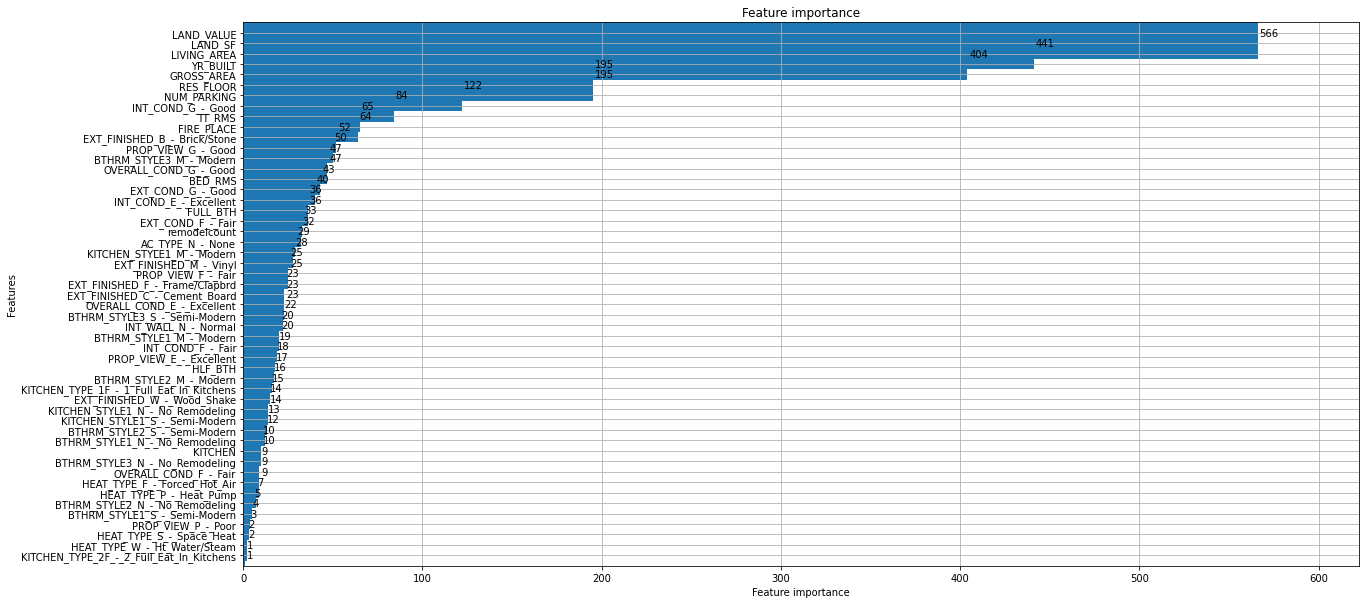

In [12]:
import lightgbm as ltb

ltb.plot_importance(model_nosearch,height=5,figsize=(20,10))

# End User functionality
__Functions below can be used by end user (i.e. contractor) when proposing renovation to client. The three functions include:__
- Searching for a property ID ("PID") using street numbber and street name
- Searching for property information using PID from previous step to get current property information
- Modifying property features and getting back a predicted price

In [155]:

# functions for home remodel pricing changes
# follow workflow in cells below
# the user will first find the PID by entering the house number and street name
# the user will then input the PID to pull the property details
# the user will then input proposed changes to the property and get back the models prediction for building price


def getPID(add="", street=""):
    street=street.upper()
    items=["PID","ST_NUM","ST_NAME","CITY","ZIPCODE"]
    try:
        df3[(df3["ST_NUM"].astype(str).str.contains(add)) & df3["ST_NAME"].str.contains(street)]
        potential=df3[(df3["ST_NUM"].str.contains(add)) & df3["ST_NAME"].str.contains(street)]
        # print(potential)
        if len(potential)==0:
            print("property not found")
        for index,row in potential.iterrows():
            for item in items:
              print(row[item])
    except:
        print("property not found")
        
def getPropRecord(pid):
  
  record=df3[df3["PID"]==pid]
  col=record.columns
  cols2=["RES_FLOOR","BLDG_TYPE","RES_FLOOR","LIVING_AREA","LAND_SF","BLDG_VALUE","YR_REMODEL","ROOF_STRUCTURE","ROOF_COVER","INT_WALL","EXT_FINISHED","INT_COND","EXT_COND","OVERALL_COND","BED_RMS","FULL_BTH",
  "HLF_BTH","KITCHEN","BDRM_COND","BTHRM_STYLE1","BTHRM_STYLE2","BTHRM_STYLE3","KITCHEN_TYPE","KITCHEN_STYLE1","KITCHEN_STYLE2","KITCHEN_STYLE3"]
  for index,row in record.iterrows():
    # for item in col:
    for item in cols2:
      print(item,"|",row[item])


def predictnew(pid="",attr=[],new=[]):
  currentprice=df3[df3["PID"]==pid]["BLDG_VALUE"]
#   print(currentprice)
  record=df3[df3["PID"]==pid]
#   display(record)
  for id,a in enumerate(attr):
    record.at[1,a]=new[id]

#   display(record)
  # print(record.shape)
  record=record.drop(fdrop,axis=1)
#   print(record.shape)
  Xpre=record.select_dtypes(include=['object']).columns.tolist()
  Xprenot=record.select_dtypes(exclude=['object']).columns.tolist()
  # print(Xprenot)
  xnums=record[Xprenot]
  xcats=record[Xpre]
  X1=xcats
  X1hot=pd.get_dummies(X1, prefix=Xpre,drop_first=True)
  record=pd.concat([X1hot,xnums],axis=1)
  newrecord=[]
  for i in list(X_train.columns):
    try:
      newrecord.append(record.iloc[0][i])
    except:
      newrecord.append(0)
  # print(len(newrecord))
  newrecord=pd.DataFrame([newrecord])
  # display(newrecord)
  newrecord.columns=list(X_train.columns)
#   print(newrecord.shape)
#   display(newrecord)
  
  
  newprice=amt_m01_GB.predict(scalermaxabsX.transform(newrecord.values.reshape(1,-1)))
#   newprice=amt_m01_Tree.predict(scalerX.transform(newrecord.values.reshape(1,-1)))
#   print("done")
  print("Current price:",currentprice)
  print("New price:",newprice) 
  print("Property Value Increase:",newprice[0]-currentprice)

# Example use case

In [114]:
# this function gets the PID based on the street number and street name, use this to find the PID for the property you want to work with
getPID("412","BREMEN")

100336000
412  
BREMEN ST
EAST BOSTON
2128


In [145]:
# this function gets the property record, use this to see what you might want to propose as a change to the client
getPropRecord("100336000")

RES_FLOOR | 1.5
BLDG_TYPE | CP - Cape
RES_FLOOR | 1.5
LIVING_AREA | 1035.3
LAND_SF | 1295.0
BLDG_VALUE | 226600.0
YR_REMODEL | nan
ROOF_STRUCTURE | G - Gable
ROOF_COVER | A - Asphalt Shingl
INT_WALL | N - Normal
EXT_FINISHED | M - Vinyl
INT_COND | A - Average
EXT_COND | A - Average
OVERALL_COND | A - Average
BED_RMS | 3
FULL_BTH | 1
HLF_BTH | 0
KITCHEN | 1
BDRM_COND | nan
BTHRM_STYLE1 | S - Semi-Modern
BTHRM_STYLE2 | nan
BTHRM_STYLE3 | nan
KITCHEN_TYPE | 1F - 1 Full Eat In Kitchens
KITCHEN_STYLE1 | S - Semi-Modern
KITCHEN_STYLE2 | nan
KITCHEN_STYLE3 | nan


In [159]:
# this function predicts the new building value based on changes to selected features, you have to input proposed change into the attr field and the new value in the respective index in new list, use default
# values from cells below
# in this example, we are setting the interior condition to excellent from the current status
# see field Current price: for current price, field New price: and field 
# In this example, we offer the client expanding the living area of the building from 1035.3 to 1500

predictnew("100336000",attr=["LIVING_AREA"],new=[1500])


Current price: 24    226600.0
Name: BLDG_VALUE, dtype: float64
New price: [413660.72254137]
Property Value Increase: 24    187060.722541
Name: BLDG_VALUE, dtype: float64


/var/folders/j0/ynr213yd3xv8z6ky7v66rpn40000gn/T/ipykernel_1443/452023140.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  record.at[1,a]=new[id]
/Users/richren/opt/anaconda3/envs/threeeight/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MaxAbsScaler was fitted with feature names
  warnings.warn(


In [ ]:
# function cell shows the values that you can use for each of the attribute fields
cols2=["RES_FLOOR","BLDG_TYPE","RES_FLOOR","LIVING_AREA","LAND_SF","BLDG_VALUE","YR_REMODEL","ROOF_STRUCTURE","ROOF_COVER","INT_WALL","EXT_FINISHED","INT_COND","EXT_COND","OVERALL_COND","BED_RMS","FULL_BTH",
  "HLF_BTH","KITCHEN","BDRM_COND","BTHRM_STYLE1","BTHRM_STYLE2","BTHRM_STYLE3","KITCHEN_TYPE","KITCHEN_STYLE1","KITCHEN_STYLE2","KITCHEN_STYLE3"]
for i in cols2:
  try:
    print(i,":||||||",df3[i].unique())
  except:
    pass

RES_FLOOR :|||||| [ 2.   1.5  1.   3.   2.5  3.5  4.   4.5  5.  19. ]
BLDG_TYPE :|||||| ['CL - Colonial' 'CP - Cape' 'RE - Row End' 'RM - Row Middle'
 'CV - Conventional' 'RR - Raised Ranch' 'RN - Ranch' 'BW - Bungalow'
 'CN - Contemporary' 'SL - Split Level' 'TL - Tri-Level' 'TD - Tudor'
 'SD - Semi-Det' 'VT - Victorian' 'OT - Other' 'DK - Decker'
 'TF - Two Fam Stack' 'FS - Free Standing' 'BL - Bi-Level']
RES_FLOOR :|||||| [ 2.   1.5  1.   3.   2.5  3.5  4.   4.5  5.  19. ]
LIVING_AREA :|||||| [1122.  1968.  1110.6 ... 3122.  2149.9 2390.4]
LAND_SF :|||||| [ 1238.  1650.  2500. ... 12602. 12105.  5794.]
BLDG_VALUE :|||||| [210500. 328400. 301800. ... 648900. 614000. 536600.]
YR_REMODEL :|||||| [1965. 1980.   nan 2017. 1996. 2014. 2018. 1986. 2002. 1981. 2000. 2020.
 1985. 2001. 1975. 1993. 2004. 2013. 1999. 1997. 2011. 2016. 2006. 1978.
 1984. 2012. 1994. 1983. 2003. 2019. 2005. 2015. 1995. 2010. 1970. 2007.
 2008. 1990. 1991. 1969. 2009. 1998. 1987. 1963. 1977. 1979. 1992. 1973.
 19

In [ ]:
# function to get google map street view image of address
import os
import urllib.parse
import urllib.request

myloc = r"/content/streetimages" #replace with your own location
key = "&key=" + "" #you need an actual key now!!

def GetStreet(Add,SaveLoc):
  base = "https://maps.googleapis.com/maps/api/streetview?size=1200x800&location="
  MyUrl = base + urllib.parse.quote_plus(Add) + key #added url encoding
  fi = Add + ".jpg"
  urllib.request.urlretrieve(MyUrl, os.path.join(SaveLoc,fi))

Tests = ["113 Elm St, Charlestown, MA 02129"]

for i in Tests:
  GetStreet(Add=i,SaveLoc=myloc)